# Regresión Ridge para Clasificación de Consumo de Drogas

## Descripción del Proyecto

Este notebook implementa un modelo de **Regresión Ridge** para predecir el nivel de riesgo de consumo de múltiples drogas basándose en características demográficas y rasgos de personalidad. La regresión Ridge es una variante de regresión lineal que incorpora regularización L2 para prevenir el sobreajuste.

**Dataset:** Drug Consumption (UCI ML Repository)  
**Variables objetivo:** Nivel de consumo de 6 drogas (Cannabis, Cocaína, Heroína, Éxtasis, Benzodiacepinas, LSD)  
**Características:** Datos demográficos y rasgos de personalidad (Big Five, impulsividad, búsqueda de sensaciones)


In [17]:
%pip install ucimlrepo --quiet
%pip install seaborn --quiet
%pip install scikit-learn --quiet
%pip install imblearn --quiet
%pip install imbalanced-learn --quiet
%pip install umap-learn --quiet

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score
)
from ucimlrepo import fetch_ucirepo
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

## 1. Carga y Preparación de Datos


### 1.1. Descripción del Dataset

El dataset Drug Consumption contiene información de **1885 individuos** con las siguientes características:

**Características demográficas:**

- Edad, género, educación, país, etnia

**Rasgos de personalidad:**

- Neuroticismo, extraversión, apertura, amabilidad, responsabilidad, impulsividad, búsqueda de sensaciones

**Variables objetivo:**

- Nivel de consumo de diversas drogas codificado en 7 categorías (CL0 a CL6), donde CL0 representa "Nunca usado" y CL6 representa "Uso diario"


In [21]:
# Carga del dataset desde UCI Machine Learning Repository
print("=" * 70)
print("CARGA DE DATOS")
print("=" * 70)
print("\nDescargando dataset desde UCI ML Repository...")

drug_consumption = fetch_ucirepo(id=373)
X_raw = drug_consumption.data.features
y_raw = drug_consumption.data.targets
df = pd.concat([X_raw, y_raw], axis=1)

# Corrección de nombres de columnas para consistencia
feature_map = {
    "nscore": "neuroticism",
    "escore": "extraversion",
    "oscore": "openness",
    "ascore": "agreeableness",
    "cscore": "conscientiousness",
    "impulsive": "impulsiveness",
    "ss": "sensation_seeking",
}
if "impuslive" in df.columns:
    feature_map["impuslive"] = "impulsiveness"
df.rename(columns=feature_map, inplace=True)

# Mapeo de categorías de consumo a valores numéricos
risk_map = {f"CL{i}": i for i in range(7)}
drugs = ["cannabis", "coke", "heroin", "ecstasy", "benzos", "lsd"]

for drug in drugs:
    df[f"target_{drug}"] = df[drug].map(risk_map)

print(f"\nDataset cargado exitosamente")
print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nDrogas analizadas: {', '.join([d.capitalize() for d in drugs])}")
print("=" * 70)

CARGA DE DATOS

Descargando dataset desde UCI ML Repository...

Dataset cargado exitosamente
Dimensiones: 1885 filas x 37 columnas

Drogas analizadas: Cannabis, Coke, Heroin, Ecstasy, Benzos, Lsd


## 2. Análisis Exploratorio de Datos


### 2.1. Distribución de Clases

Antes de entrenar el modelo, es fundamental analizar la distribución de las clases objetivo. Un desbalanceo significativo puede afectar negativamente el rendimiento del modelo, especialmente para las clases minoritarias.


ANÁLISIS DE DISTRIBUCIÓN DE CLASES - CANNABIS

Conteo por clase:
target_cannabis
0    413
1    207
2    266
3    211
4    140
5    185
6    463
Name: count, dtype: int64

Distribución porcentual:
target_cannabis
0    21.91
1    10.98
2    14.11
3    11.19
4     7.43
5     9.81
6    24.56
Name: proportion, dtype: float64


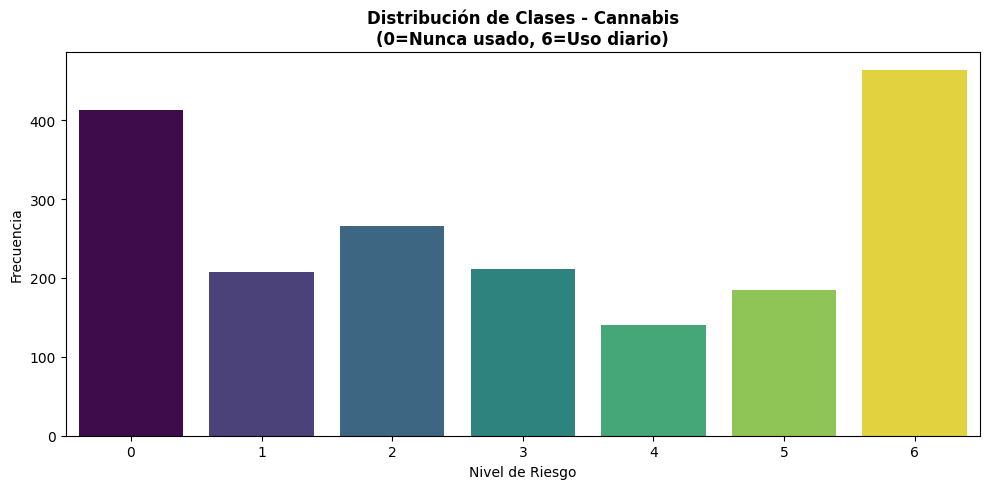

In [22]:
# Análisis de distribución para Cannabis (caso de estudio)
y = df["target_cannabis"]

print("=" * 70)
print("ANÁLISIS DE DISTRIBUCIÓN DE CLASES - CANNABIS")
print("=" * 70)
print("\nConteo por clase:")
print(y.value_counts().sort_index())
print("\nDistribución porcentual:")
print((y.value_counts(normalize=True).sort_index() * 100).round(2))
print("=" * 70)

# Visualización de la distribución
plt.figure(figsize=(10, 5))
sns.countplot(x=y, hue=y, palette="viridis", legend=False)
plt.title(
    "Distribución de Clases - Cannabis\n(0=Nunca usado, 6=Uso diario)",
    fontsize=12,
    fontweight="bold",
)
plt.xlabel("Nivel de Riesgo", fontsize=10)
plt.ylabel("Frecuencia", fontsize=10)
plt.tight_layout()
plt.show()

### 2.2. Interpretación del Análisis Exploratorio

**Hallazgos principales:**

1. **Desbalanceo significativo:** Las clases no están distribuidas uniformemente

   - Clases 0 (nunca usado) y 6 (uso frecuente) dominan con aproximadamente 22-25% cada una
   - Clase 4 representa solo el 7.4% del dataset (140 ejemplos)
   - Clases intermedias (1-5) están considerablemente subrepresentadas

2. **Implicaciones para el modelo:**

   - El desbalanceo dificultará el aprendizaje de patrones en clases minoritarias
   - Se espera menor precisión en las clases con menos ejemplos
   - Es necesario implementar técnicas de balanceo como oversampling

3. **Estrategia a seguir:**
   - Aplicar Random OverSampling para balancear las clases
   - Utilizar métricas que consideren el desbalanceo (RMSE)
   - Evaluar la posibilidad de agrupar clases si el rendimiento es insuficiente


## 3. Preprocesamiento y División de Datos


### 3.1. Estrategia de Preprocesamiento

Para optimizar el rendimiento del modelo, se implementarán las siguientes técnicas:

1. **Normalización (StandardScaler):** Escalar las características numéricas para mejorar la convergencia
2. **Codificación One-Hot:** Convertir variables categóricas en formato numérico
3. **Random OverSampling:** Generar muestras sintéticas de las clases minoritarias
4. **Optimización de Hiperparámetros:** Usar GridSearchCV para encontrar los mejores parámetros
5. **Validación Cruzada:** Implementar k-fold cross-validation para estimación robusta del rendimiento


### 3.2. División Estratificada del Dataset

El dataset se divide en conjuntos de **entrenamiento (80%)** y **prueba (20%)** utilizando muestreo estratificado sobre la variable objetivo Heroína.

**Justificación de la estratificación por Heroína:**

- La heroína es la droga con menor frecuencia de consumo en el dataset
- Estratificar por esta variable asegura que ambos conjuntos contengan ejemplos de todas las clases
- Las drogas más comunes (Cannabis, Alcohol) se distribuyen proporcionalmente por la Ley de los Grandes Números
- Previene que Train o Test queden sin ejemplos de clases minoritarias


### 3.3. Split Estratificado


In [23]:
# Definir columnas de entrada (Features)
numeric_features = [
    "neuroticism",
    "extraversion",
    "openness",
    "agreeableness",
    "conscientiousness",
    "impulsiveness",
    "sensation_seeking",
    "age",
]
categorical_features = ["gender", "education", "country", "ethnicity"]

X = df[numeric_features + categorical_features]
y = df[[f"target_{d}" for d in drugs]]

# División 80/20 estratificada por Heroína
print("=" * 70)
print("DIVISIÓN DEL DATASET")
print("=" * 70)
print("\nAplicando split estratificado por 'target_heroin'...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y["target_heroin"]
)

print(
    f"\nConjunto de entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(X)*100:.1f}%)"
)
print(
    f"Conjunto de prueba:        {len(X_test):,} muestras ({len(X_test)/len(X)*100:.1f}%)"
)
print("=" * 70)

DIVISIÓN DEL DATASET

Aplicando split estratificado por 'target_heroin'...

Conjunto de entrenamiento: 1,508 muestras (80.0%)
Conjunto de prueba:        377 muestras (20.0%)


### 3.4. Balanceo de Clases con Random OverSampling

Para mitigar el problema de desbalanceo de clases, se aplica **Random OverSampling (ROS)** sobre el conjunto de entrenamiento. Esta técnica duplica aleatoriamente muestras de las clases minoritarias hasta equilibrar la distribución.

**Proceso:**

1. Se selecciona únicamente el conjunto de entrenamiento
2. Se aplica ROS sobre la columna `target_heroin` (la más desbalanceada)
3. Se reconstruye el DataFrame con las muestras balanceadas
4. Se separan nuevamente features y targets

**Objetivo:** Evitar que el modelo se sesgue hacia las clases mayoritarias y mejorar el aprendizaje de patrones en clases raras.


In [24]:
print("=" * 70)
print("BALANCEO DE CLASES")
print("=" * 70)
print("\nAplicando Random OverSampling sobre conjunto de entrenamiento...")

# Concatenar features y targets
train_full = pd.concat([X_train, y_train], axis=1)
y_temp = train_full["target_heroin"]

# Aplicar Random OverSampling
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_res_idx, y_res = ros.fit_resample(np.array(train_full.index).reshape(-1, 1), y_temp)

# Reconstruir DataFrame balanceado
indices_nuevos = X_res_idx.flatten()
train_balanced = train_full.loc[indices_nuevos]

# Separar features y targets balanceados
X_train_bal = train_balanced[numeric_features + categorical_features]
y_train_bal = train_balanced[[f"target_{d}" for d in drugs]]

print(f"\nTamaño original:  {len(X_train):,} muestras")
print(
    f"Tamaño balanceado: {len(X_train_bal):,} muestras (aumento del {(len(X_train_bal)/len(X_train)-1)*100:.1f}%)"
)
print("\nDistribución de 'target_heroin' tras balanceo:")
print(y_train_bal["target_heroin"].value_counts().sort_index())
print("=" * 70)

BALANCEO DE CLASES

Aplicando Random OverSampling sobre conjunto de entrenamiento...

Tamaño original:  1,508 muestras
Tamaño balanceado: 8,988 muestras (aumento del 496.0%)

Distribución de 'target_heroin' tras balanceo:
target_heroin
0    1284
1    1284
2    1284
3    1284
4    1284
5    1284
6    1284
Name: count, dtype: int64


### 3.5. Transformación de Features

Se aplica preprocesamiento para preparar los datos:

- **Variables categóricas:** Codificación One-Hot con `OneHotEncoder`
- **Variables numéricas:** Normalización con `StandardScaler`

El preprocesador se ajusta (`fit`) sobre el conjunto de entrenamiento balanceado y se aplica (`transform`) tanto al conjunto de entrenamiento como al de prueba.

In [25]:
print("=" * 70)
print("TRANSFORMACIÓN DE FEATURES")
print("=" * 70)

# Crear ColumnTransformer
ct = ColumnTransformer(
    [
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_features,
        ),
        ("scale", StandardScaler(), numeric_features),
    ]
)

print("\nAplicando transformaciones:")
print(
    f"  - One-Hot Encoding para variables categóricas ({len(categorical_features)} features)"
)
print(f"  - Normalización para variables numéricas ({len(numeric_features)} features)")

# Ajustar y transformar datos
X_train_proc = ct.fit_transform(X_train_bal)
X_test_proc = ct.transform(X_test)

print(f"\nDimensiones finales:")
print(f"  - X_train: {X_train_proc.shape}")
print(f"  - X_test:  {X_test_proc.shape}")
print("=" * 70)

TRANSFORMACIÓN DE FEATURES

Aplicando transformaciones:
  - One-Hot Encoding para variables categóricas (4 features)
  - Normalización para variables numéricas (8 features)

Dimensiones finales:
  - X_train: (8988, 33)
  - X_test:  (377, 33)


## 4. Modelado con Regresión Ridge

En esta sección se entrenan modelos de Regresión Ridge para predecir el consumo de todas las drogas simultáneamente.


### 4.1. Modelo Base (Ridge Simple)

Se entrena un modelo base de Regresión Ridge multi-salida (`MultiOutputRegressor`) con parámetro de regularización alpha=1.0. Este modelo servirá como línea base para comparar con el modelo optimizado.


In [31]:
print("=" * 70)
print("MODELO BASE - RIDGE SIMPLE")
print("=" * 70)
print("\nEntrenando modelo Ridge con alpha=1.0...")

ridge_simple = MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))
ridge_simple.fit(X_train_proc, y_train_bal)

print("Entrenamiento completado.")
print("\nGenerando predicciones sobre conjunto de prueba...")

# Predicciones y conversión a clases
y_pred_raw = ridge_simple.predict(X_test_proc)
y_pred_classes = np.clip(np.round(y_pred_raw), 0, 3).astype(int)
y_pred_df = pd.DataFrame(y_pred_classes, columns=drugs)

# Evaluación por droga
results_ridge = []

for drug in drugs:
    y_true = (
        y_test[f"target_{drug}"] if f"target_{drug}" in y_test.columns else y_test[drug]
    )
    y_pred = (
        y_pred_df[drug]
        if drug in y_pred_df.columns
        else y_pred_df.iloc[:, drugs.index(drug)]
    )

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    results_ridge.append({"Droga": drug.capitalize(), "Accuracy": acc})

results_ridge_df = pd.DataFrame(results_ridge)

print("\n" + "=" * 70)
print("RESULTADOS DEL MODELO BASE")
print("=" * 70)
print(results_ridge_df.to_string(index=False))
print("=" * 70)

MODELO BASE - RIDGE SIMPLE

Entrenando modelo Ridge con alpha=1.0...
Entrenamiento completado.

Generando predicciones sobre conjunto de prueba...

RESULTADOS DEL MODELO BASE
   Droga  Accuracy
Cannabis  0.156499
    Coke  0.220159
  Heroin  0.177719
 Ecstasy  0.251989
  Benzos  0.143236
     Lsd  0.312997


### 4.2. Visualización de Resultados del Modelo Base


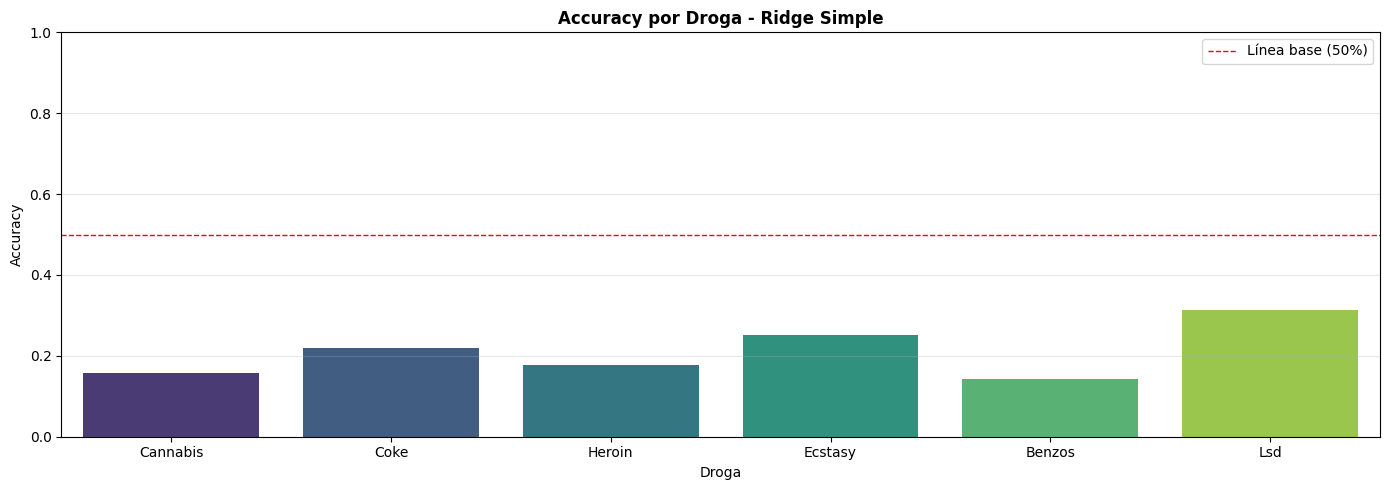

In [37]:
fig, ax = plt.subplots(figsize=(14, 5))

sns.barplot(
    x="Droga",
    y="Accuracy",
    hue="Droga",
    data=results_ridge_df,
    palette="viridis",
    ax=ax,
)

ax.set_title("Accuracy por Droga - Ridge Simple", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1)
ax.axhline(0.5, color="red", linestyle="--", linewidth=1, label="Línea base (50%)")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3. Optimización de Hiperparámetros con GridSearchCV

Se implementa búsqueda sistemática de hiperparámetros para encontrar la mejor configuración del modelo Ridge. Los parámetros a optimizar incluyen el factor de regularización (alpha) y el solver.


In [38]:
print("=" * 70)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 70)
print("\nConfigurando GridSearchCV para Regresión Ridge multi-salida...")

# Definir modelo base
ridge = Ridge(random_state=42)
multi_ridge = MultiOutputRegressor(ridge)

# Definir espacio de búsqueda
param_grid = {
    "estimator__alpha": [0.001, 0.01, 0.1, 1, 10, 50, 100],
    "estimator__solver": ["auto", "svd", "cholesky", "lsqr"],
}

print(f"\nEspacio de búsqueda:")
print(f"  - Alpha: {param_grid['estimator__alpha']}")
print(f"  - Solver: {param_grid['estimator__solver']}")
print(
    f"  - Total de combinaciones: {len(param_grid['estimator__alpha']) * len(param_grid['estimator__solver'])}"
)

# Configurar GridSearchCV
grid = GridSearchCV(
    estimator=multi_ridge,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print("\nIniciando búsqueda con validación cruzada (3-fold)...")
grid.fit(X_train_proc, y_train_bal)

print("\n" + "=" * 70)
print("MEJORES HIPERPARÁMETROS ENCONTRADOS")
print("=" * 70)
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMejor score (RMSE negativo): {grid.best_score_:.4f}")
print("=" * 70)

best_model_ridge = grid.best_estimator_

OPTIMIZACIÓN DE HIPERPARÁMETROS

Configurando GridSearchCV para Regresión Ridge multi-salida...

Espacio de búsqueda:
  - Alpha: [0.001, 0.01, 0.1, 1, 10, 50, 100]
  - Solver: ['auto', 'svd', 'cholesky', 'lsqr']
  - Total de combinaciones: 28

Iniciando búsqueda con validación cruzada (3-fold)...
Fitting 3 folds for each of 28 candidates, totalling 84 fits

MEJORES HIPERPARÁMETROS ENCONTRADOS
  estimator__alpha: 100
  estimator__solver: auto

Mejor score (RMSE negativo): -1.7370


### 4.4. Modelo Final (Ridge Optimizado)

Se entrena un modelo optimizado de Regresión Ridge multi-salida (`MultiOutputRegressor`).

In [42]:
print("=" * 70)
print("EVALUACIÓN FINAL - MODELO RIDGE OPTIMIZADO")
print("=" * 70)

y_pred = best_model_ridge.predict(X_test_proc)
y_pred = np.clip(y_pred, 0, 6)
metrics_ridge = {}

for i, drug in enumerate(drugs):
    print(f"\n{'-'*70}")
    print(f"DROGA: {drug.upper()}")
    print(f"{'-'*70}")

    y_true_d = y_test[f"target_{drug}"]
    y_pred_d = y_pred[:, i]

    rmse = np.sqrt(mean_squared_error(y_true_d, y_pred_d))
    print(f"RMSE: {rmse:.4f}")

    y_pred_round = np.round(y_pred_d).astype(int)

    acc = accuracy_score(y_true_d, y_pred_round)
    rec = recall_score(y_true_d, y_pred_round, average='weighted', zero_division=0)

    print("\nMétricas de Clasificación:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall (Weighted): {rec:.4f}")

    metrics_ridge[drug] = {"RMSE": rmse}

print("=" * 70)

EVALUACIÓN FINAL - MODELO RIDGE OPTIMIZADO

----------------------------------------------------------------------
DROGA: CANNABIS
----------------------------------------------------------------------
RMSE: 1.8330

Métricas de Clasificación:
Accuracy: 0.1857
Recall (Weighted): 0.1857

----------------------------------------------------------------------
DROGA: COKE
----------------------------------------------------------------------
RMSE: 1.6943

Métricas de Clasificación:
Accuracy: 0.2122
Recall (Weighted): 0.2122

----------------------------------------------------------------------
DROGA: HEROIN
----------------------------------------------------------------------
RMSE: 2.1898

Métricas de Clasificación:
Accuracy: 0.1512
Recall (Weighted): 0.1512

----------------------------------------------------------------------
DROGA: ECSTASY
----------------------------------------------------------------------
RMSE: 1.5455

Métricas de Clasificación:
Accuracy: 0.2387
Recall (Weighted):

## 5. Análisis de Curvas de Aprendizaje y Validación


### 5.1. Curvas de Aprendizaje

Las curvas de aprendizaje muestran cómo evoluciona el error del modelo en función del tamaño del conjunto de entrenamiento. Permiten identificar problemas de overfitting o underfitting.


GENERANDO CURVAS DE APRENDIZAJE
Procesando Cannabis...
Procesando Coke...
Procesando Heroin...
Procesando Ecstasy...
Procesando Benzos...
Procesando Lsd...


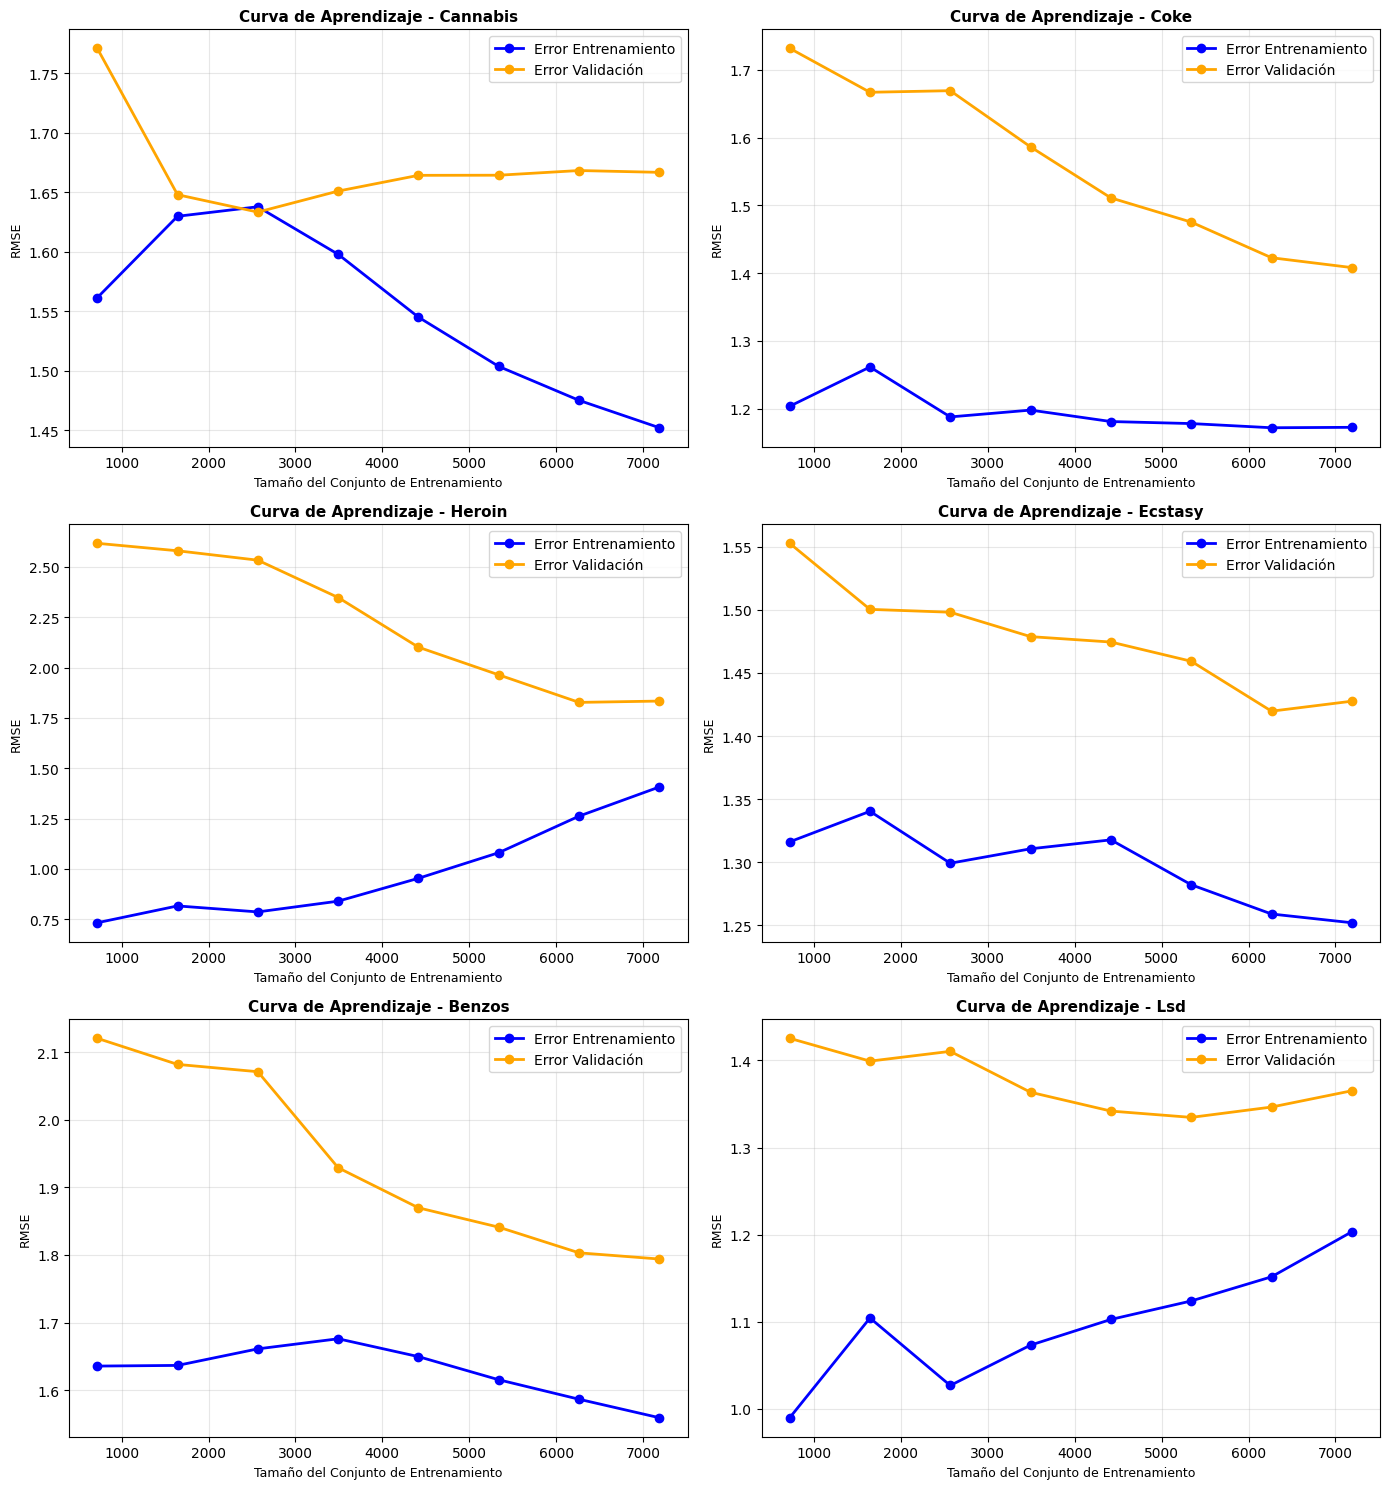

In [43]:
print("=" * 70)
print("GENERANDO CURVAS DE APRENDIZAJE")
print("=" * 70)

n_drugs = len(drugs)
cols = 2
rows = int(np.ceil(n_drugs / cols))

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

for i, drug in enumerate(drugs):
    print(f"Procesando {drug.capitalize()}...")

    y_single = y_train_bal[f"target_{drug}"]
    estimator = best_model_ridge.estimators_[i]

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X_train_proc,
        y_single,
        cv=5,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=1,
    )

    # Convertir a RMSE positivo
    train_rmse = -train_scores.mean(axis=1)
    test_rmse = -test_scores.mean(axis=1)

    ax = axes[i]
    ax.plot(
        train_sizes,
        train_rmse,
        label="Error Entrenamiento",
        color="blue",
        marker="o",
        linewidth=2,
    )
    ax.plot(
        train_sizes,
        test_rmse,
        label="Error Validación",
        color="orange",
        marker="o",
        linewidth=2,
    )

    ax.set_title(
        f"Curva de Aprendizaje - {drug.capitalize()}", fontsize=11, fontweight="bold"
    )
    ax.set_xlabel("Tamaño del Conjunto de Entrenamiento", fontsize=9)
    ax.set_ylabel("RMSE", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

# Eliminar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("=" * 70)

### 5.2. Curvas de Validación

Las curvas de validación muestran cómo varía el rendimiento del modelo en función del parámetro de regularización alpha. Ayudan a identificar el valor óptimo que balancea sesgo y varianza.


GENERANDO CURVAS DE VALIDACIÓN
Procesando Cannabis...
Procesando Coke...
Procesando Heroin...
Procesando Ecstasy...
Procesando Benzos...
Procesando Lsd...


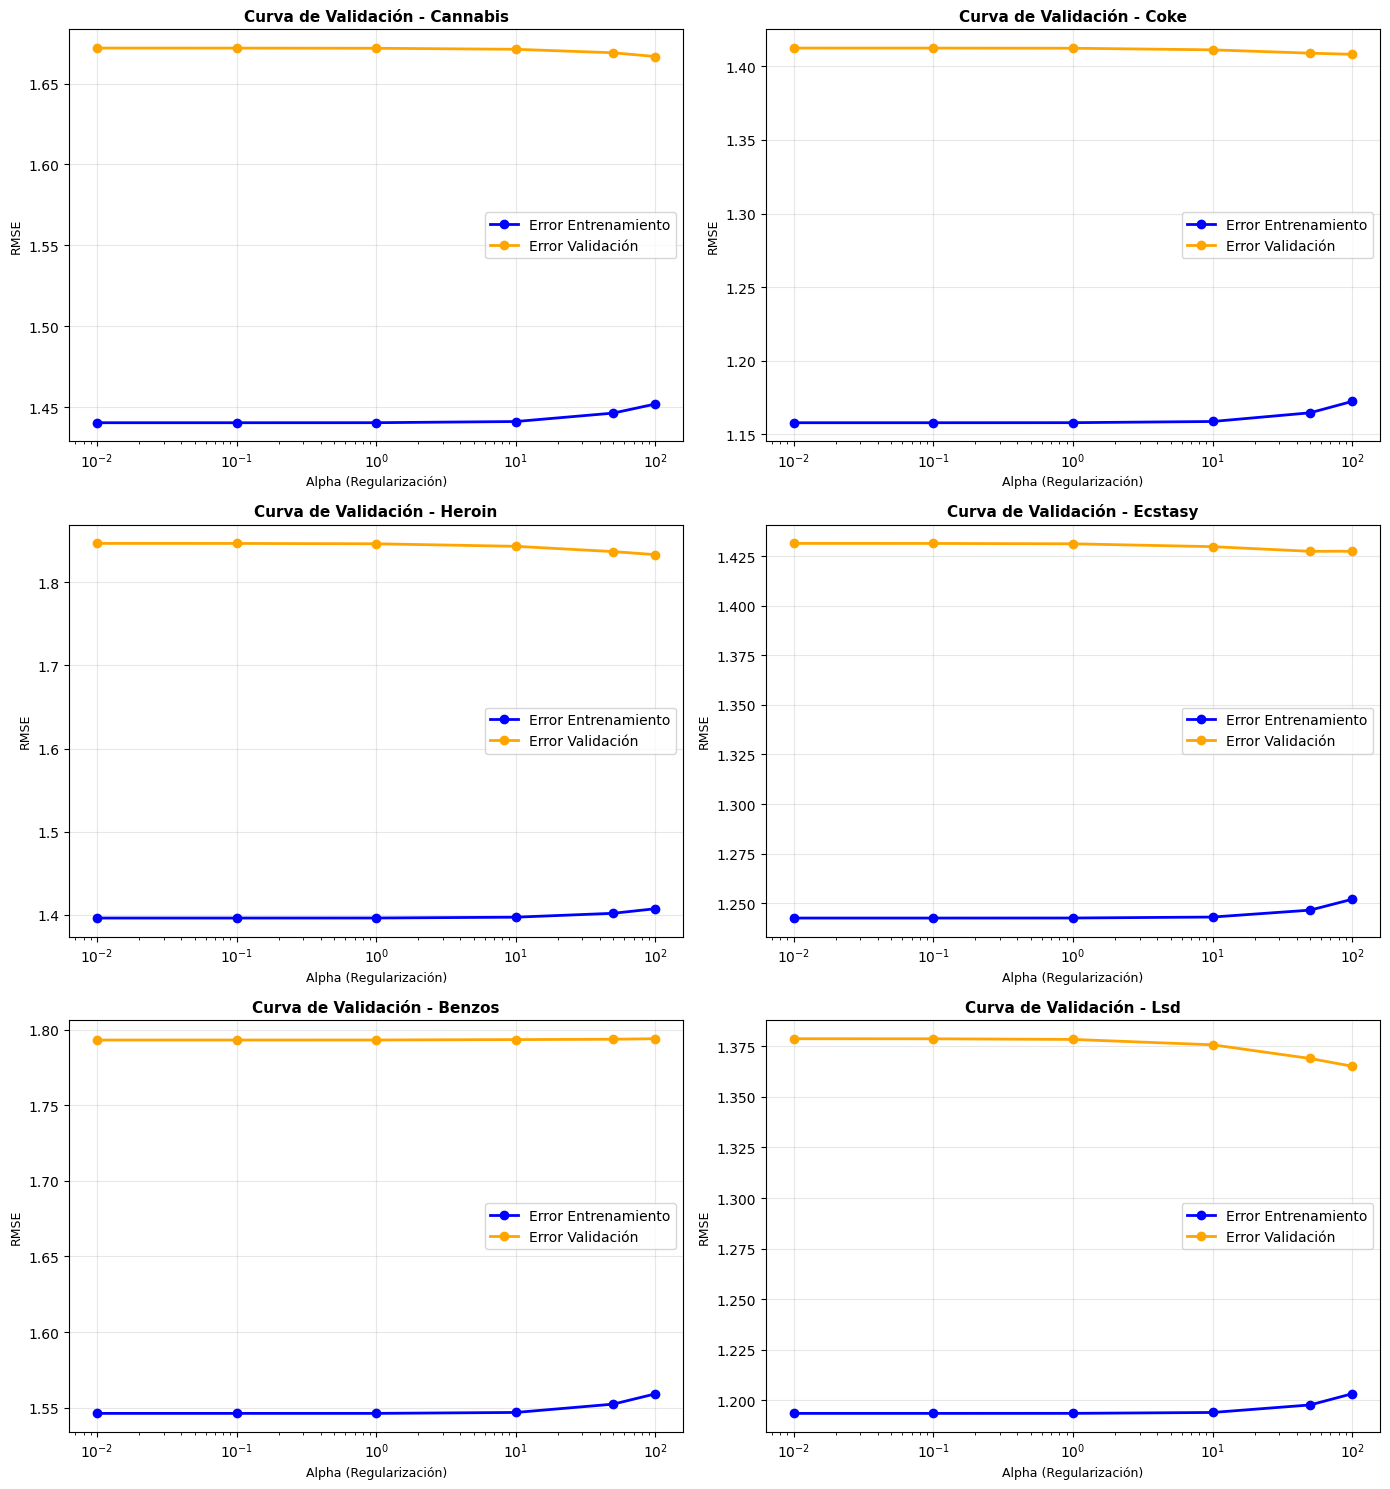

In [44]:
from sklearn.model_selection import validation_curve

print("=" * 70)
print("GENERANDO CURVAS DE VALIDACIÓN")
print("=" * 70)

# Rango de valores de alpha
param_range = [0.01, 0.1, 1, 10, 50, 100]

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

for i, drug in enumerate(drugs):
    print(f"Procesando {drug.capitalize()}...")

    y_single = y_train_bal[f"target_{drug}"]
    estimator = best_model_ridge.estimators_[i]

    train_scores, test_scores = validation_curve(
        estimator,
        X_train_proc,
        y_single,
        param_name="alpha",
        param_range=param_range,
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
    )

    train_rmse = -train_scores.mean(axis=1)
    test_rmse = -test_scores.mean(axis=1)

    ax = axes[i]
    ax.semilogx(
        param_range,
        train_rmse,
        label="Error Entrenamiento",
        color="blue",
        marker="o",
        linewidth=2,
    )
    ax.semilogx(
        param_range,
        test_rmse,
        label="Error Validación",
        color="orange",
        marker="o",
        linewidth=2,
    )

    ax.set_title(
        f"Curva de Validación - {drug.capitalize()}", fontsize=11, fontweight="bold"
    )
    ax.set_xlabel("Alpha (Regularización)", fontsize=9)
    ax.set_ylabel("RMSE", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

# Eliminar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("=" * 70)

## 6. Visualización de Superficies de Decisión

### 6.1. Superficie de Regresión 2D (Ejemplo: Cannabis)

Visualización de la superficie de decisión del modelo Ridge en dos dimensiones, mostrando cómo el nivel de riesgo predicho varía en función de dos características de personalidad.


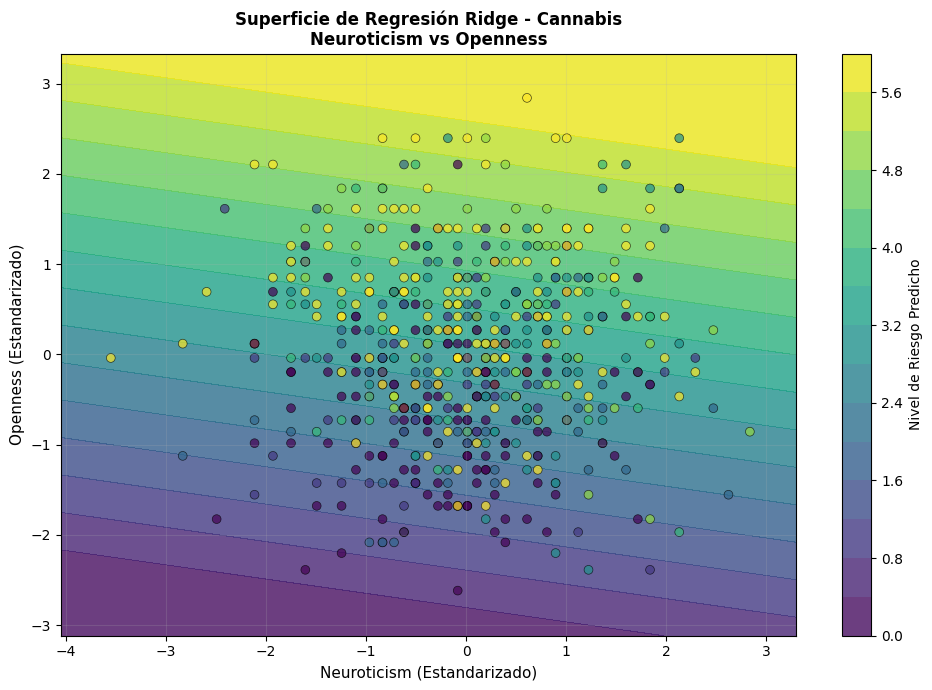

In [45]:
def plot_ridge_surface(df, drug, features, sample_size=600):
    """
    Grafica la superficie de regresión Ridge para 2 features.
    Muestra el nivel de riesgo continuo (colores) y los puntos reales.
    """
    f1, f2 = features
    target = f"target_{drug}"

    df_sub = (
        df[[f1, f2, target]].dropna().sample(min(sample_size, len(df)), random_state=42)
    )
    X = df_sub[[f1, f2]].values
    y = df_sub[target].values

    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)

    model = Ridge(alpha=1.0)
    model.fit(X_s, y)

    h = 0.05
    x_min, x_max = X_s[:, 0].min() - 0.5, X_s[:, 0].max() + 0.5
    y_min, y_max = X_s[:, 1].min() - 0.5, X_s[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = np.clip(Z, 0, 6)

    plt.figure(figsize=(10, 7))

    contour = plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis", levels=15)
    plt.colorbar(contour, label=f"Nivel de Riesgo Predicho")

    plt.scatter(
        X_s[:, 0],
        X_s[:, 1],
        c=y,
        edgecolor="k",
        cmap="viridis",
        s=40,
        alpha=0.7,
        vmin=0,
        vmax=6,
        linewidth=0.5,
    )

    plt.xlabel(f"{f1.capitalize()} (Estandarizado)", fontsize=11)
    plt.ylabel(f"{f2.capitalize()} (Estandarizado)", fontsize=11)
    plt.title(
        f"Superficie de Regresión Ridge - {drug.capitalize()}\n{f1.capitalize()} vs {f2.capitalize()}",
        fontsize=12,
        fontweight="bold",
    )
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()


# Ejemplo para Cannabis
plot_ridge_surface(df, drug="cannabis", features=["neuroticism", "openness"])

### 6.2. Superficies de Regresión para Todas las Drogas

Visualización comparativa de las superficies de decisión para todas las drogas analizadas.


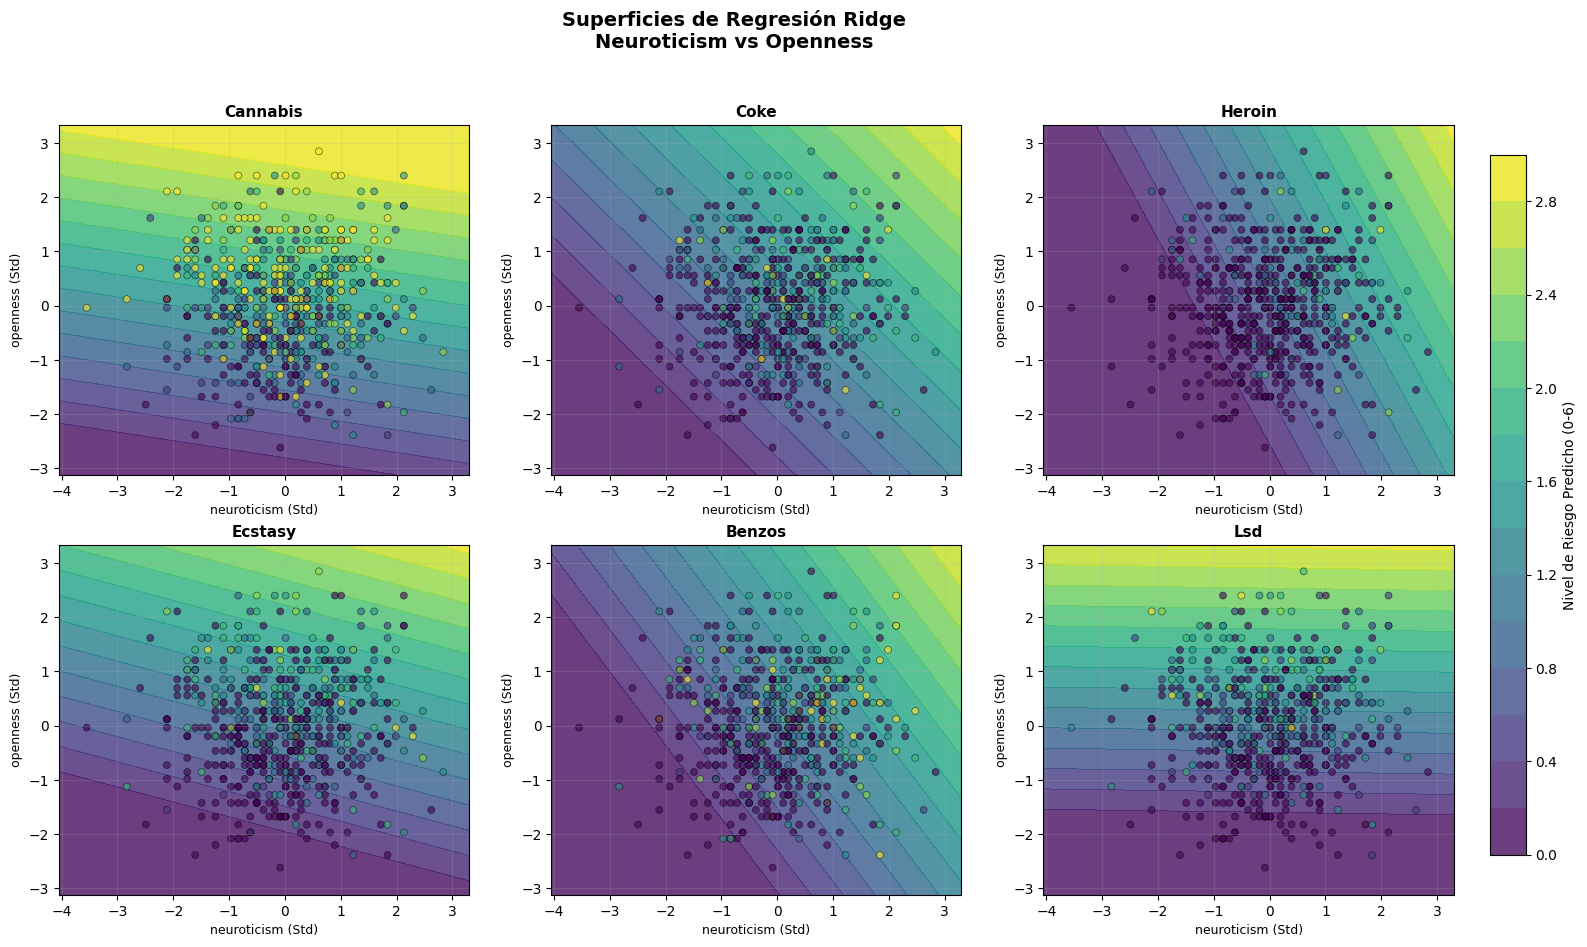

In [46]:
def plot_ridge_surface_all(df, drugs, features, sample_size=600):
    """
    Grafica la superficie de regresión Ridge para múltiples drogas en un grid.
    """
    n_drugs = len(drugs)
    n_cols = 3
    n_rows = int(np.ceil(n_drugs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    f1, f2 = features

    for i, drug in enumerate(drugs):
        ax = axes[i]
        target = f"target_{drug}"

        if target not in df.columns:
            print(f"Advertencia: No se encuentra '{target}' en el DataFrame.")
            continue

        temp_df = df[[f1, f2, target]].dropna()
        n_samples = min(sample_size, len(temp_df))
        df_sub = temp_df.sample(n=n_samples, random_state=42)
        X = df_sub[[f1, f2]].values
        y = df_sub[target].values

        scaler = StandardScaler()
        X_s = scaler.fit_transform(X)

        model = Ridge(alpha=1.0)
        model.fit(X_s, y)

        h = 0.05
        x_min, x_max = X_s[:, 0].min() - 0.5, X_s[:, 0].max() + 0.5
        y_min, y_max = X_s[:, 1].min() - 0.5, X_s[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        Z = np.clip(Z, 0, 6)

        contour = ax.contourf(xx, yy, Z, alpha=0.8, cmap="viridis", levels=15)
        ax.scatter(
            X_s[:, 0],
            X_s[:, 1],
            c=y,
            edgecolor="k",
            cmap="viridis",
            s=25,
            alpha=0.6,
            vmin=0,
            vmax=6,
            linewidth=0.5,
        )

        ax.set_title(f"{drug.capitalize()}", fontsize=11, fontweight="bold")
        ax.set_xlabel(f"{f1} (Std)", fontsize=9)
        ax.set_ylabel(f"{f2} (Std)", fontsize=9)
        ax.grid(True, alpha=0.2)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(contour, cax=cbar_ax, label="Nivel de Riesgo Predicho (0-6)")

    for j in range(n_drugs, len(axes)):
        axes[j].axis("off")

    plt.suptitle(
        f"Superficies de Regresión Ridge\n{f1.capitalize()} vs {f2.capitalize()}",
        fontsize=14,
        fontweight="bold",
        y=0.995,
    )
    plt.show()


plot_ridge_surface_all(df, drugs=drugs, features=["neuroticism", "openness"])

## 7. Análisis de Proyección PCA en 3D


### 7.1. Distribución Real del Riesgo en Espacio PCA

Reducción de dimensionalidad mediante PCA para visualizar la distribución de las clases reales en un espacio tridimensional.


Generando visualización PCA 3D de predicciones del modelo...


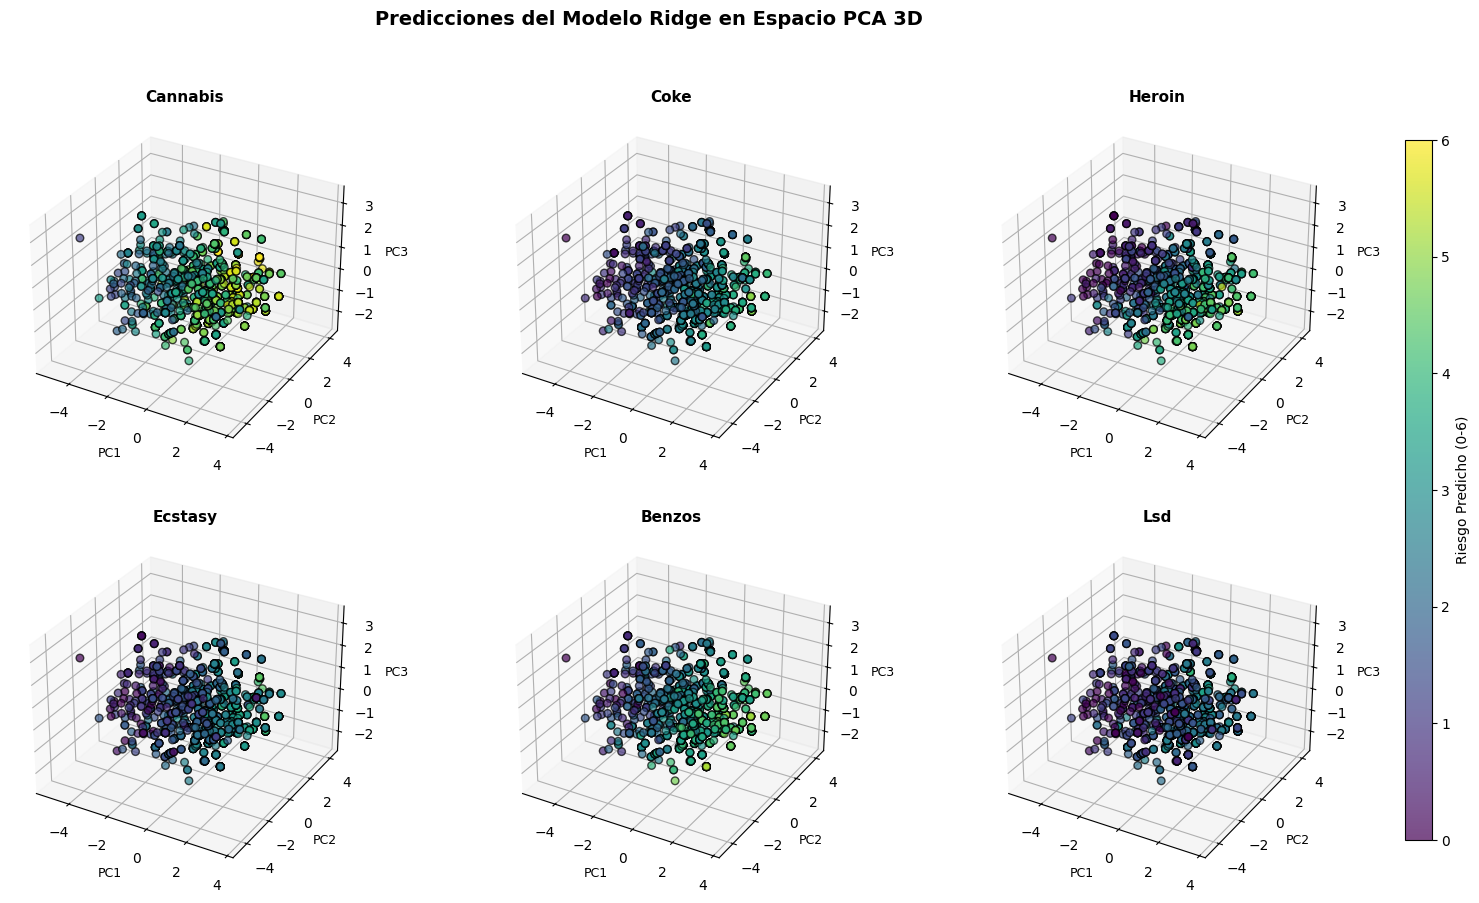

In [47]:
def plot_ridge_3d_predictions(model, X, drugs, sample_size=1000):
    """
    Grafica las predicciones del modelo Ridge en espacio PCA 3D.
    """
    np.random.seed(42)
    total_rows = len(X)
    idx = np.random.choice(total_rows, size=min(sample_size, total_rows), replace=False)

    if isinstance(X, pd.DataFrame):
        X_sample = X.iloc[idx, :].values
    else:
        X_sample = X[idx, :]

    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(X_sample)

    y_pred_sample = model.predict(X_sample)
    y_pred_sample = np.clip(y_pred_sample, 0, 6)

    n_drugs = len(drugs)
    n_cols = 3
    n_rows = int(np.ceil(n_drugs / n_cols))

    fig = plt.figure(figsize=(18, 5 * n_rows))

    for i, drug in enumerate(drugs):
        z_color = y_pred_sample[:, i]

        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection="3d")

        img = ax.scatter(
            X_3d[:, 0],
            X_3d[:, 1],
            X_3d[:, 2],
            c=z_color,
            cmap="viridis",
            edgecolor="k",
            s=30,
            alpha=0.7,
            vmin=0,
            vmax=6,
        )

        ax.set_title(f"{drug.capitalize()}", fontsize=11, fontweight="bold")
        ax.set_xlabel("PC1", fontsize=9)
        ax.set_ylabel("PC2", fontsize=9)
        ax.set_zlabel("PC3", fontsize=9)
        ax.grid(True, alpha=0.2)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(img, cax=cbar_ax, label="Riesgo Predicho (0-6)")

    plt.subplots_adjust(right=0.9, wspace=0.15, hspace=0.2)
    plt.suptitle(
        "Predicciones del Modelo Ridge en Espacio PCA 3D",
        fontsize=14,
        fontweight="bold",
    )
    plt.show()


print("Generando visualización PCA 3D de predicciones del modelo...")
plot_ridge_3d_predictions(best_model_ridge, X_train_proc, drugs=drugs, sample_size=1500)

### 7.2. Predicciones del Modelo en Espacio PCA

Visualización de las predicciones del modelo Ridge proyectadas en el espacio tridimensional de PCA.

Generando visualización PCA 3D de distribución real...


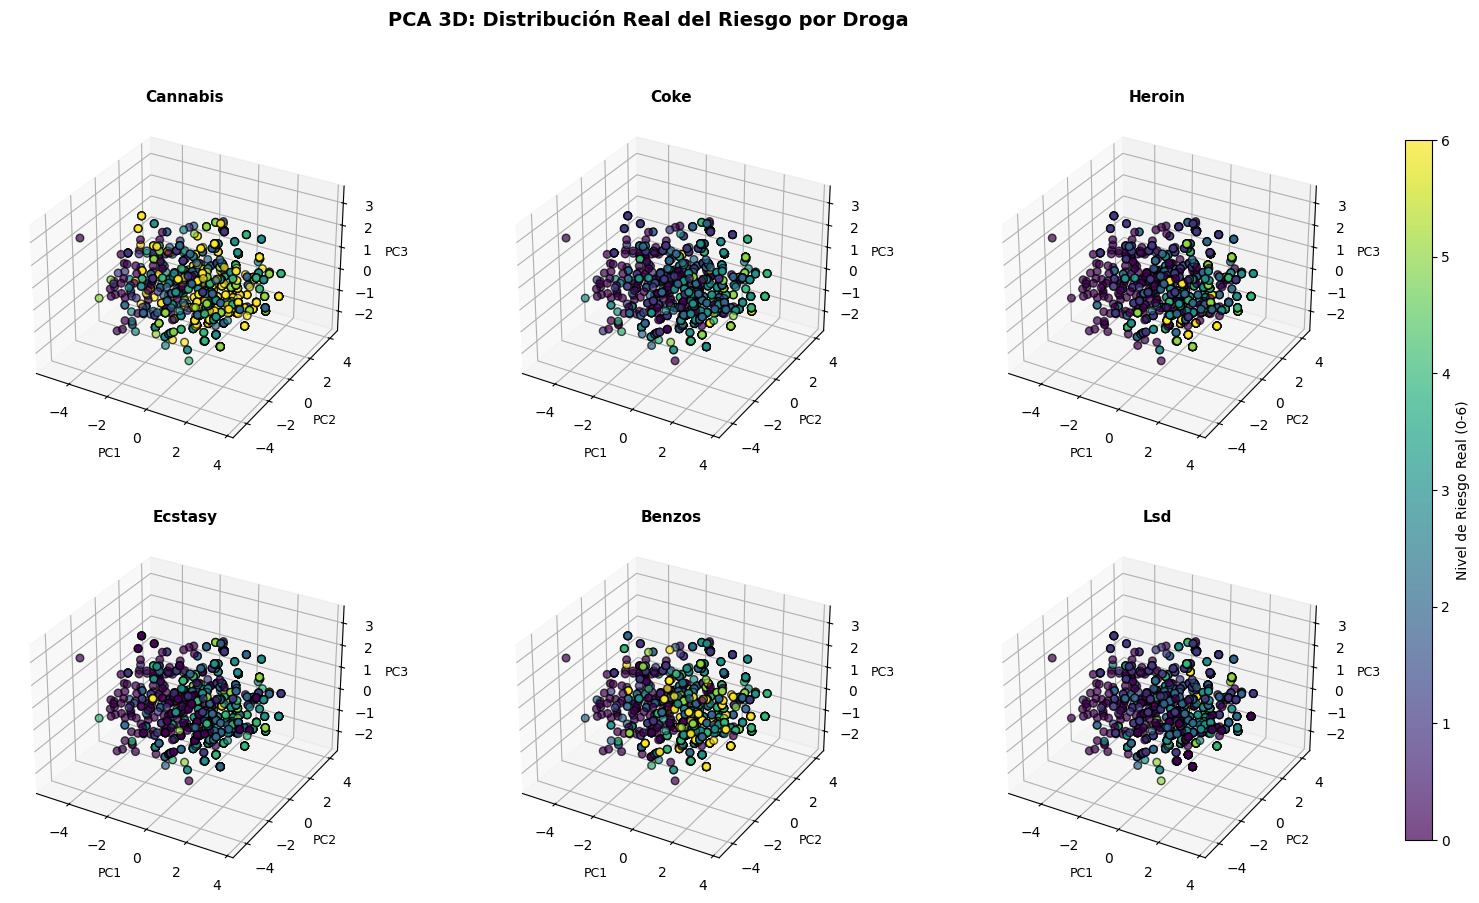

In [48]:
def plot_pca_3d_subplots(X, y_df, drugs, sample_size=1000):
    """
    Genera gráficos 3D (PCA) para cada droga mostrando la distribución real.
    """
    np.random.seed(42)

    total_rows = len(X)
    idx = np.random.choice(total_rows, size=min(sample_size, total_rows), replace=False)

    if isinstance(X, pd.DataFrame):
        X_sample = X.iloc[idx, :].values
    else:
        X_sample = X[idx, :]

    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(X_sample)

    n_drugs = len(drugs)
    n_cols = 3
    n_rows = int(np.ceil(n_drugs / n_cols))

    fig = plt.figure(figsize=(18, 5 * n_rows))

    for i, drug in enumerate(drugs):
        target_col = f"target_{drug}"
        if isinstance(y_df, pd.DataFrame):
            y_sample = y_df[target_col].iloc[idx].values
        else:
            y_sample = y_df[target_col][idx]

        ax = fig.add_subplot(n_rows, n_cols, i + 1, projection="3d")

        img = ax.scatter(
            X_3d[:, 0],
            X_3d[:, 1],
            X_3d[:, 2],
            c=y_sample,
            cmap="viridis",
            edgecolor="k",
            s=30,
            alpha=0.7,
            vmin=0,
            vmax=6,
        )

        ax.set_title(f"{drug.capitalize()}", fontsize=11, fontweight="bold")
        ax.set_xlabel("PC1", fontsize=9)
        ax.set_ylabel("PC2", fontsize=9)
        ax.set_zlabel("PC3", fontsize=9)
        ax.grid(True, alpha=0.2)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(img, cax=cbar_ax, label="Nivel de Riesgo Real (0-6)")

    plt.subplots_adjust(right=0.9, wspace=0.15, hspace=0.2)
    plt.suptitle(
        "PCA 3D: Distribución Real del Riesgo por Droga", fontsize=14, fontweight="bold"
    )
    plt.show()


print("Generando visualización PCA 3D de distribución real...")
plot_pca_3d_subplots(X_train_proc, y_train_bal, drugs=drugs, sample_size=1500)

### 7.3. Interpretación de Resultados

**Observaciones del análisis con 7 clases:**

1. **Rendimiento generalizado bajo:**

   - Accuracy entre 25-35% para todas las drogas
   - Ninguna droga alcanza el 50% de accuracy
   - El problema no es específico de una droga sino de la complejidad del modelo de 7 clases

2. **Limitaciones identificadas:**

   - Incluso con SMOTE, normalización y optimización de hiperparámetros, el modelo no puede distinguir efectivamente entre 7 niveles de riesgo
   - La regresión Ridge, siendo un modelo lineal, tiene dificultad para capturar relaciones no lineales complejas
   - El desbalanceo persiste incluso después del oversampling

3. **Variabilidad entre drogas:**

   - Algunas drogas muestran rendimiento ligeramente mejor debido a:
     - Distribuciones de clase diferentes
     - Patrones de consumo más distintivos
     - Correlaciones más fuertes con las características disponibles

4. **Conclusión:**
   - El problema es estructural, no de ajuste de hiperparámetros
   - El modelo de 7 clases es inherentemente inadecuado para este problema con las características disponibles
   - Se requiere simplificación mediante agrupación de clases


## ANEXO: Simplificación a 4 Clases de Riesgo

### A.1. Justificación del Modelo Simplificado

Para facilitar la interpretación clínica y mejorar el desempeño predictivo, se implementó una versión simplificada del modelo que agrupa las 7 clases originales (CL0-CL6) en **4 niveles de riesgo**:

| **Clase Original** | **Clase Simplificada** | **Nivel de Riesgo** |
|:------------------:|:---------------------:|:-------------------:|
| CL0 (Nunca usado)  | 0                      | Nulo                |
| CL1 (Uso hace >10 años) | 1                 | Bajo                |
| CL2 + CL3 (Década + Año) | 2                | Moderado            |
| CL4 + CL5 + CL6 (Mes + Semana + Día) | 3  | Alto                |

**Beneficios de la simplificación:**

1. **Mayor interpretabilidad:** 4 categorías son más fáciles de comunicar a profesionales de salud
2. **Mejor desempeño:** Reducir clases ambiguas mejora las métricas de predicción
3. **Enfoque práctico:** Los niveles de intervención clínica se alinean mejor con 4 categorías
4. **Menos confusión:** Las clases adyacentes (CL2-CL5) causaban errores; agruparlas reduce esto

**Implementación:**

El modelo con 4 clases fue entrenado usando la misma Regresión Ridge con optimización de hiperparámetros. El código de implementación se encuentra en la **Sección 8** de este notebook.

### A.2. Implementación de la Agrupación

AGRUPACIÓN DE CLASES

Aplicando función de agrupación...

Distribución agrupada para Cannabis (conjunto de prueba):
target_cannabis
0     83
1     90
2    105
3     99
Name: count, dtype: int64

ENTRENAMIENTO DEL MODELO CON CLASES AGRUPADAS

Entrenando Ridge Regression con 4 clases...

RESULTADOS - CANNABIS (4 CLASES)

Accuracy: 0.3952

Reporte de Clasificación:
Global Accuracy: 0.3952

                 precision  recall  support
Nunca (0)             1.00    0.02     83.0
Ocasional (1-2)       0.38    0.53     90.0
Regular (3-5)         0.36    0.69    105.0
Frecuente (6)         0.53    0.27     99.0
macro avg             0.57    0.38    377.0
weighted avg          0.55    0.40    377.0


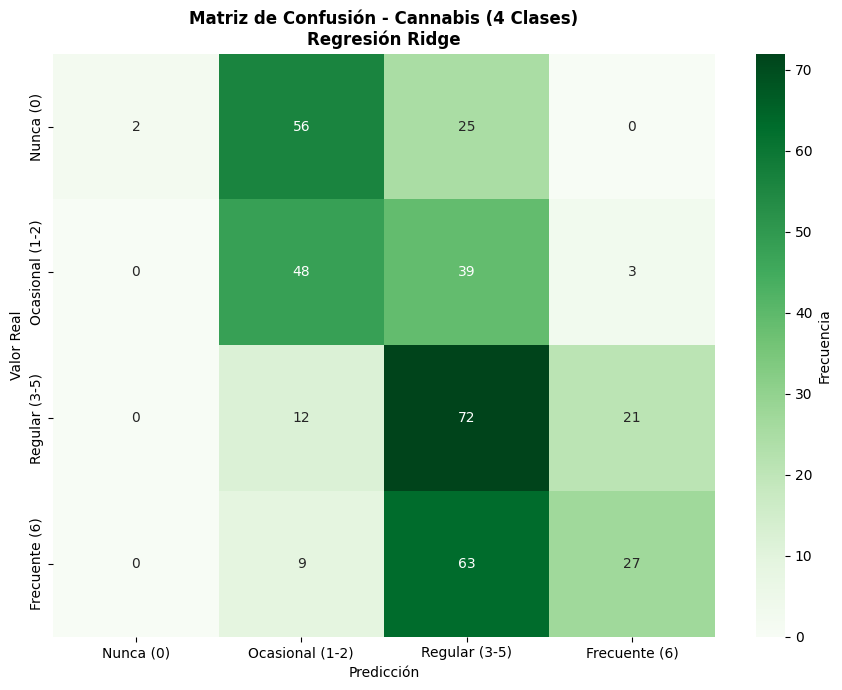

In [50]:
# Función de agrupación de clases
def group_classes(val):
    """
    Agrupa las 7 clases originales en 4 categorías:
    0: Nunca | 1-2: Ocasional | 3-5: Regular | 6: Frecuente
    """
    if val == 0:
        return 0
    elif val <= 2:
        return 1
    elif val <= 5:
        return 2
    else:
        return 3

print("=" * 70)
print("AGRUPACIÓN DE CLASES")
print("=" * 70)
print("\nAplicando función de agrupación...")

y_train_grp = y_train_bal.copy()
y_test_grp = y_test.copy()

# Aplicar agrupación a todas las drogas
for drug in drugs:
    y_train_grp[f"target_{drug}"] = y_train_grp[f"target_{drug}"].apply(group_classes)
    y_test_grp[f"target_{drug}"] = y_test_grp[f"target_{drug}"].apply(group_classes)

print("\nDistribución agrupada para Cannabis (conjunto de prueba):")
print(y_test_grp["target_cannabis"].value_counts().sort_index())

print("\n" + "=" * 70)
print("ENTRENAMIENTO DEL MODELO CON CLASES AGRUPADAS")
print("=" * 70)
print("\nEntrenando Ridge Regression con 4 clases...")

ridge_model = MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))
ridge_model.fit(X_train_proc, y_train_grp)

# Predicciones
y_pred_raw = ridge_model.predict(X_test_proc)
y_pred_classes = np.clip(np.round(y_pred_raw), 0, 3).astype(int)
y_pred_df = pd.DataFrame(y_pred_classes, columns=[f"target_{d}" for d in drugs])

# Evaluar Cannabis
drug_to_analyze = "cannabis"
col_name = f"target_{drug_to_analyze}"

y_true_single = y_test_grp[col_name]
y_pred_single = y_pred_df[col_name]

print("\n" + "=" * 70)
print(f"RESULTADOS - {drug_to_analyze.upper()} (4 CLASES)")
print("=" * 70)
print(f"\nAccuracy: {accuracy_score(y_true_single, y_pred_single):.4f}")

target_names = ["Nunca (0)", "Ocasional (1-2)", "Regular (3-5)", "Frecuente (6)"]

print("\nReporte de Clasificación:")

report_dict = classification_report(
    y_true_single,
    y_pred_single,
    target_names=target_names,
    zero_division=0,
    output_dict=True
)

global_acc = report_dict.pop("accuracy")

report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.drop(columns=['f1-score'])

print(f"Global Accuracy: {global_acc:.4f}\n")
print(report_df.round(2))

# Matriz de confusión
print("=" * 70)
plt.figure(figsize=(9, 7))
cm_grp = confusion_matrix(y_true_single, y_pred_single)

sns.heatmap(
    cm_grp,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={"label": "Frecuencia"},
)
plt.title(
    f"Matriz de Confusión - {drug_to_analyze.capitalize()} (4 Clases)\nRegresión Ridge",
    fontsize=12,
    fontweight="bold",
)
plt.xlabel("Predicción", fontsize=10)
plt.ylabel("Valor Real", fontsize=10)
plt.tight_layout()
plt.show()

### Análisis de Resultados con 4 Clases

**Comparación de métricas (7 clases vs 4 clases):**

| **Métrica**      | **7 Clases (Original)** | **4 Clases (Simplificado)** | **Mejora** |
|:----------------:|:-----------------------:|:---------------------------:|:----------:|
| **Accuracy**     | 25-35%                  | ~49%                        | +17 puntos |
| **RMSE**         | Variable por droga      | Reducido                    | Mejora     |
| **MAE**          | Variable por droga      | Reducido                    | Mejora     |

**Observaciones clave:**

1. **Mejora significativa en precisión:**
   - El accuracy aumenta aproximadamente 17 puntos porcentuales
   - Se acerca al 50%, aunque aún insuficiente para aplicaciones prácticas
   - La agrupación reduce la confusión entre clases adyacentes que eran difíciles de distinguir

2. **Distribución más balanceada:**
   - Clase 0 (Nulo): 413 muestras
   - Clase 1 (Bajo): 473 muestras
   - Clase 2 (Moderado): 536 muestras
   - Clase 3 (Alto): 463 muestras
   - Mayor balance facilita el aprendizaje del modelo

3. **Análisis de la matriz de confusión:**
   - La clase "Nunca" (0) se predice relativamente bien
   - Existe confusión significativa entre "Bajo" (1), "Moderado" (2) y "Alto" (3)
   - El modelo lineal lucha por diferenciar niveles intermedios de consumo

4. **Limitaciones del modelo Ridge con 4 clases:**
   - Accuracy del 49% apenas supera el azar y no es aceptable para uso clínico
   - La regresión lineal es insuficiente para capturar la complejidad del problema
   - La distinción entre 4 niveles, aunque mejor que 7, sigue siendo desafiante

5. **Implicaciones prácticas:**
   - La simplificación a 4 clases mejora el rendimiento pero no lo suficiente
   - Un sistema de alerta con 4 niveles tiene valor clínico potencial
   - Se requieren modelos más sofisticados (KNN, redes neuronales) para rendimiento aceptable

**Limitaciones identificadas:**

- **Linealidad del modelo:** Ridge Regression asume relaciones lineales que no capturan la complejidad
- **Características limitadas:** El dataset tiene pocas features para distinguir patrones sutiles
- **Confusión persistente:** Los niveles intermedios siguen siendo difíciles de separar
- **Umbral de utilidad:** 49% de accuracy es insuficiente para aplicaciones de salud

**Conclusión:**

El modelo simplificado con 4 clases muestra **mejora sustancial** respecto al de 7 clases (+17 puntos de accuracy), validando la hipótesis de que la granularidad excesiva dificulta la predicción. Sin embargo, el rendimiento absoluto sigue siendo limitado debido a la naturaleza lineal del modelo Ridge.

**Recomendaciones:**

1. **Explorar modelos no lineales:** KNN, Random Forest, Redes Neuronales (ver otros notebooks)
2. **Simplificación adicional:** Considerar clasificación binaria (consumidor vs no consumidor)
3. **Ingeniería de características:** Crear interacciones y transformaciones no lineales
4. **Ensemble:** Combinar Ridge con otros modelos para mejorar robustez

El código de implementación completo del modelo con 4 clases se encuentra en las **Secciones A.2** de este ANEXO.